In [1]:
import pandas as pd
df = pd.read_csv('data/daily_data.csv', parse_dates=True, index_col=0)


In [2]:
df.head()

,kWh,Voltage,Global_reactive_power,Kitchen,Laundry_Room,Water_Heater_AC,day_of_week,month,year,day_of_year,is_weekend,kWh_rolling_mean_7,kWh_rolling_std_7,kWh_lag_1,kWh_lag_7,kWh_lag_30
Datetime,,,,,,,,,,,,,,,,
2007-01-15,35.811300,241.240910,0.121431,1099.0,2239.0,15163.0,0,1,2007,15,0,38.302060,10.154146,50.183817,37.356000,20.152933
2007-01-16,28.106733,241.944757,0.128769,2063.0,644.0,6583.0,1,1,2007,16,0,37.867179,10.568206,35.811300,31.150900,56.507667
2007-01-17,47.461467,241.005250,0.139411,3500.0,5737.0,16064.0,2,1,2007,17,0,39.516912,11.100326,28.106733,35.913333,36.730433
2007-01-18,30.357700,240.893597,0.123411,0.0,336.0,13491.0,3,1,2007,18,0,38.484217,11.633308,47.461467,37.586567,27.769900
2007-01-19,24.674000,240.160944,0.118092,2103.0,330.0,7172.0,4,1,2007,19,0,38.529798,11.569169,30.357700,24.354933,37.095800


## Forecasting (Next 7 Days)

In [12]:
df_copy= df.copy()
df_reset = df_copy.reset_index()

# create the Prophet-compatible DataFrame
df_prophet = df_reset[['Datetime', 'kWh']].rename(columns={'Datetime': 'ds', 'kWh': 'y'})

14:38:02 - cmdstanpy - INFO - Chain [1] start processing


Train size: 1129, Test size: 283


14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:02 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.01, seasonality_prior_scale=1: 4.634


14:38:02 - cmdstanpy - INFO - Chain [1] done processing
14:38:03 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.01, seasonality_prior_scale=5: 4.647


14:38:03 - cmdstanpy - INFO - Chain [1] done processing
14:38:03 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.01, seasonality_prior_scale=10: 4.643


14:38:03 - cmdstanpy - INFO - Chain [1] done processing
14:38:03 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.01, seasonality_prior_scale=20: 4.629


14:38:03 - cmdstanpy - INFO - Chain [1] done processing
14:38:03 - cmdstanpy - INFO - Chain [1] start processing
14:38:04 - cmdstanpy - INFO - Chain [1] done processing


MAE with changepoint_prior_scale=0.05, seasonality_prior_scale=1: 4.617


14:38:04 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.05, seasonality_prior_scale=5: 4.619


14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.05, seasonality_prior_scale=10: 4.621


14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.05, seasonality_prior_scale=20: 4.620


14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.1, seasonality_prior_scale=1: 4.596


14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.1, seasonality_prior_scale=5: 4.595


14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing
14:38:05 - cmdstanpy - INFO - Chain [1] done processing


MAE with changepoint_prior_scale=0.1, seasonality_prior_scale=10: 4.592


14:38:05 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.1, seasonality_prior_scale=20: 4.594


14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.5, seasonality_prior_scale=1: 4.556


14:38:06 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.5, seasonality_prior_scale=5: 4.562


14:38:06 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing


MAE with changepoint_prior_scale=0.5, seasonality_prior_scale=10: 4.561


14:38:06 - cmdstanpy - INFO - Chain [1] done processing


MAE with changepoint_prior_scale=0.5, seasonality_prior_scale=20: 4.561

Best MAE: 4.556 with params changepoint_prior_scale=0.5, seasonality_prior_scale=1


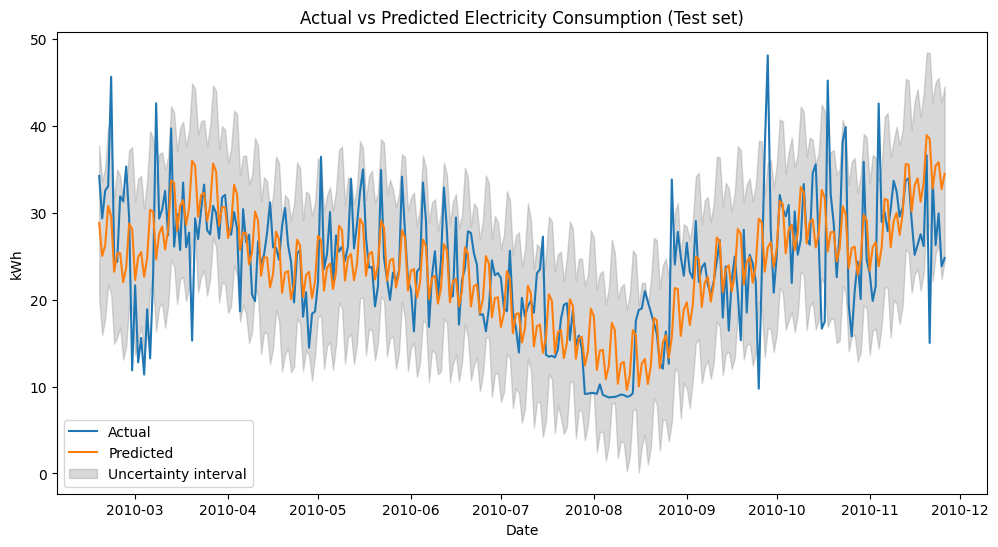

Final MAE on test set: 4.556


In [17]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# --- Split into train and test ---
train_size = int(len(df_prophet)*0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

# --- Define a function to train and evaluate Prophet with given hyperparameters ---
def train_and_evaluate(train, test, changepoint_prior_scale=0.05, seasonality_prior_scale=10):
    model = Prophet(
        daily_seasonality=False,
        yearly_seasonality=True,
        weekly_seasonality=True,
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(train)

    # Make future dataframe for the test period
    future = test[['ds']].copy()

    # Predict
    forecast = model.predict(future)

    # Calculate MAE on test set
    mae = mean_absolute_error(test['y'], forecast['yhat'])
    print(f"MAE with changepoint_prior_scale={changepoint_prior_scale}, seasonality_prior_scale={seasonality_prior_scale}: {mae:.3f}")

    return model, forecast, mae

# --- Tune hyperparameters by grid search ---
import itertools

changepoint_prior_scale_vals = [0.01, 0.05, 0.1, 0.5]
seasonality_prior_scale_vals = [1, 5, 10, 20]

best_mae = float('inf')
best_params = None
best_model = None
best_forecast = None

for cps, sps in itertools.product(changepoint_prior_scale_vals, seasonality_prior_scale_vals):
    model, forecast, mae = train_and_evaluate(train_df, test_df, cps, sps)
    if mae < best_mae:
        best_mae = mae
        best_params = (cps, sps)
        best_model = model
        best_forecast = forecast

print(f"\nBest MAE: {best_mae:.3f} with params changepoint_prior_scale={best_params[0]}, seasonality_prior_scale={best_params[1]}")

# --- Plot actual vs predicted on test ---
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual')
plt.plot(best_forecast['ds'], best_forecast['yhat'], label='Predicted')
plt.fill_between(best_forecast['ds'], best_forecast['yhat_lower'], best_forecast['yhat_upper'], color='gray', alpha=0.3, label='Uncertainty interval')
plt.title('Actual vs Predicted Electricity Consumption (Test set)')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.show()

# --- Optional: Evaluate final performance metrics ---
final_mae = mean_absolute_error(test_df['y'], best_forecast['yhat'])
print(f"Final MAE on test set: {final_mae:.3f}")


In [26]:
#  Pick the first 7 days from test_df to predict and compare
test_7days = test_df.iloc[:14]

#  Use model to predict on these 14 days
forecast_7days = best_model.predict(test_7days[['ds']])

# Combine actual and predicted values for comparison
compare_df = test_7days[['ds', 'y']].copy()
compare_df['yhat'] = forecast_7days['yhat'].values
compare_df['yhat_lower'] = forecast_7days['yhat_lower'].values
compare_df['yhat_upper'] = forecast_7days['yhat_upper'].values

print(compare_df)


             ds          y       yhat  yhat_lower  yhat_upper
1129 2010-02-17  34.242667  28.830098   19.964413   38.636907
1130 2010-02-18  29.352600  25.033207   16.221960   33.779799
1131 2010-02-19  32.559533  26.227467   17.527582   35.305701
1132 2010-02-20  33.062133  30.795274   22.428692   39.676922
1133 2010-02-21  45.671900  29.619235   21.330958   38.538750
1134 2010-02-22  24.567267  23.224137   14.330752   32.236909
1135 2010-02-23  24.354667  25.327989   16.455894   34.878870
1136 2010-02-24  31.904633  25.358655   17.096951   34.262965
1137 2010-02-25  31.336733  22.004759   13.329951   30.945003
1138 2010-02-26  35.335933  23.680801   14.474008   32.438378
1139 2010-02-27  29.417600  28.760309   19.733153   37.864445
1140 2010-02-28  11.861100  28.116533   19.669982   36.950889
1141 2010-03-01  21.645467  22.264625   12.971147   31.418543
1142 2010-03-02  12.781767  24.912877   15.939857   34.045743


In [27]:
from sklearn.metrics import mean_absolute_error

mae_14 = mean_absolute_error(compare_df['y'], compare_df['yhat'])
print(f"MAE for 14 days forecast: {mae_14:.3f}")


MAE for 14 days forecast: 6.707


In [35]:
import os
import pickle

# Create the path
output_path = os.path.join('..', 'artifacts', 'prophet_model.pkl')
# Save the model
with open(output_path, 'wb') as f:
    pickle.dump(best_model, f)